Archivo en el cual pocesamos la información de las columnas faltantes, agregamos información del campo descripción y de fuentes externas.

In [1]:
# importo las librerias a utilizar
import pandas as pd
import numpy as np
import geopandas as gpd
import librerias.funciones as fu
import seaborn as sns
from scipy import spatial
import matplotlib.pyplot as plt
from shapely import wkt
import re
from sentiment_analysis_spanish import sentiment_analysis
from ipywidgets import IntProgress
from IPython.display import display
# Evito el warning
pd.options.mode.chained_assignment = None 

import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go

In [2]:
# Levanto los datos de Analisis
data_location = "./data/datosPCABA.csv"
dataPCaba = pd.read_csv(data_location, sep=";")

In [3]:
#Mascara de columna rooms no nulas 
maskrooms = dataPCaba.rooms.notna()
#Genero nueva columna rooms_calc para intentar mputar valores faltantes
dataPCaba["rooms_calc"] = None
dataPCaba["rooms_calc"]=dataPCaba.loc[maskrooms, "rooms"] 

dataPCaba.rooms_calc.notna().sum()
#10605,  tomo todos los no nulos de la variable original

#PENDIENTE
#cuando armo la mascara de rooms a copiar desde rooms a rooms_calc me llevo los no nulos y los <= 6
#maskrooms = ( geo_dataP_cabaSn.rooms.notna() | geo_dataP_cabaSn.rooms<=6 )
#del dataset hay que dropear los que tengan mas de seis ambientes. Distorsionan

10605

In [4]:
#Busco la antiguenad de la propiedad en el detall
dataPCaba['antiguedad'] = dataPCaba.description.apply(lambda x: x if x is np.NaN else fu.ObtieneAntiguedad(x))
dataPCaba[dataPCaba['antiguedad']>0].head(4)

,Unnamed: 0,operation,property_type,place_name,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,description,geometry,BarrioOficial,sup_total_m2_clean,sup_cubierta_m2_clean,precio_clean,luxury,precio_x_m_clean,rooms_calc,antiguedad
15,52,sell,apartment,Caballito,-34.622211,-58.439128,110000.0,USD,1940895.0,110000.0,...,Departamento de 3 Ambientes al Contrafrente. S...,POINT (-58.43912829999999 -34.6222111),CABALLITO,50.0,50.0,110000.0,NaN,2200.000000,3.0,50.0
32,200,sell,apartment,Recoleta,-34.599427,-58.401586,380000.0,USD,6704910.0,380000.0,...,Los equipos de aire acondicionado no estan inc...,POINT (-58.4015856 -34.5994274),BALVANERA,196.0,196.0,380000.0,NaN,1938.775510,7.0,80.0
62,262,sell,apartment,Barrio Norte,-34.583782,-58.404228,98000.0,USD,1729161.0,98000.0,...,Departamento. Living/Comedor. 2 dormitorio(s)....,POINT (-58.40422750000001 -34.5837821),RECOLETA,37.0,37.0,98000.0,NaN,2648.648649,3.0,40.0
254,1397,sell,apartment,Balvanera,-34.603133,-58.394624,148000.0,USD,2611386.0,148000.0,...,CODIGO: ubicado en: Lavalle 1900 - Publicado...,POINT (-58.3946243302 -34.6031328142),BALVANERA,89.0,80.0,148000.0,NaN,1850.000000,NaN,50.0


In [5]:
#Sumo los amenities al dataset
dataPCaba['caracteristicas'] = dataPCaba.description.apply(lambda x: x if x is np.NaN else fu.obtenerCaracteristicas(x))
dataPCaba.head(4)

,Unnamed: 0,operation,property_type,place_name,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,geometry,BarrioOficial,sup_total_m2_clean,sup_cubierta_m2_clean,precio_clean,luxury,precio_x_m_clean,rooms_calc,antiguedad,caracteristicas
0,0,sell,PH,Mataderos,-34.661824,-58.508839,62000.0,USD,1093959.0,62000.0,...,POINT (-58.5088387 -34.6618237),MATADEROS,55.0,40.0,62000.0,NaN,1127.272727,NaN,NaN,|
1,2,sell,apartment,Mataderos,-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,...,POINT (-58.5229825 -34.6522615),LINIERS,55.0,55.0,72000.0,NaN,1309.090909,NaN,NaN,|
2,7,sell,apartment,Belgrano,-34.559873,-58.443362,138000.0,USD,2434941.0,138000.0,...,POINT (-58.443362 -34.5598729),BELGRANO,45.0,40.0,138000.0,NaN,3066.666667,NaN,NaN,|Piscina|Estrenar|Solarium|
3,8,sell,apartment,Belgrano,-34.559873,-58.443362,195000.0,USD,3440677.5,195000.0,...,POINT (-58.443362 -34.5598729),BELGRANO,65.0,60.0,195000.0,NaN,3000.000000,NaN,NaN,|Piscina|Estrenar|Solarium|


In [6]:
#----------------------------------------------------------------
# rooms from description, patron para imputar rooms
patron_room = "(?P<rooms>\d+|dos+|un+|tres+|cuatro+|cinco+)\s*(?P<ambiente>amb)"
regex_room = re.compile (patron_room)

#room_match contiene los match del patron
room_match = dataPCaba.description.apply(lambda x: x if x is np.NaN \
            else fu.ObtieneAmbientes(x, regex_room))
#obtengo los indices que podria imputar
mask_acompletar = dataPCaba.rooms_calc.isnull()
room_match.shape[0]

20630

In [7]:
room_match[room_match.notnull()].value_counts().sum()

474

In [8]:
#asigno  segun mask_acompletar los rooms que obtuve por match 
dataPCaba.loc[mask_acompletar,"rooms_calc"] = room_match
#----------------------------------------------------------------
print(dataPCaba.rooms_calc.isnull().sum ())
#9134 / 8994
print(dataPCaba.rooms_calc.notna().sum ())
#13848  / 13988 
#----------------------------------------------------------------
maskrooms = (dataPCaba.rooms.notna()) & (dataPCaba.rooms_calc.isna())
#----------------------------------------------------------------
maskrooms = dataPCaba.rooms.notna()
dataPCaba["rooms_calc"]=dataPCaba.loc[maskrooms, "rooms"] 
dataPCaba.rooms_calc.isnull().sum()
#Rooms
#8994 -- nulos
#13988  -- no nulos 

9867
10763


10025

In [9]:
#EXPENSASSSSSS
#Analisis de variable expenses
print('expensas en null', dataPCaba.expenses.isnull().sum())
#25506
print('expensas no nulas', dataPCaba.expenses.notna().sum())
#6588
#Mascara de columna expenses no nulas 
maskexpensas = dataPCaba.expenses.notna()
#Genero nueva columna expensas_clean para intentar imputar valores faltantes
dataPCaba["expensas_clean"]=dataPCaba.loc[maskexpensas, "expenses"] 

dataPCaba.expensas_clean.notna().sum()
#6588,  tomo todos los no nulos de la variable original

expensas en null 16284
expensas no nulas 4346


4346

In [10]:
# Busco imputar valor de expensas

#Obtengo Monto de expensas de la columna description
# Obtengo valores de la descripción, los paso a minuscula y le saco los puntos -- Moni
#Vale agrego dos puntos
patron_expensas = "expensas\:*\s*\$\s*(?P<expensas>\d+)" 
regex_expensas = re.compile (patron_expensas)

#data_expensas contiene los match del patron
data_expensas = dataPCaba.description.apply(lambda x: x if x is None else fu.limpia_expensas(x, regex_expensas))
#obtengo los indices que podria completar
mask_acompletar = dataPCaba.expensas_clean.isnull()

#del objeto match recupero el grupo expensas

#asigno  segun mask_acompletar las expensas que obtuve por match 
dataPCaba.loc[mask_acompletar,"expensas_clean"] = data_expensas
print('expensas en null', dataPCaba.expensas_clean.isnull().sum())
#25506
print('expensas no nulas', dataPCaba.expensas_clean.notna().sum())
#6588
#expensas en null 24057
#expensas no nulas 8037

expensas en null 15319
expensas no nulas 5311


In [11]:
mask_acompletar2 = dataPCaba.expensas_clean.isnull()
#print(geo_dataP_cabaSn.loc[mask_acompletar2,"expensas_clean"].shape[0])
dataPCaba.loc[mask_acompletar2,"expensas_clean"]  =  dataPCaba.loc[mask_acompletar2,"description"].apply(lambda x: x if x is np.NaN else fu.obtenerExpensas(x.lower()))

print('expensas en null', dataPCaba.expensas_clean.isnull().sum())
#23834
print('expensas no nulas', dataPCaba.expensas_clean.notna().sum())
#8260
#expensas en null 23389
#expensas no nulas 8705

expensas en null 14917
expensas no nulas 5713


In [12]:
#busco con un nuevo patrón
patron_expensas = "\$\s*(?P<expensas>\d+)\s*(?P<resto>de*\s*expensas)"
regex_expensas = re.compile (patron_expensas)

#data_expensas contiene los match del patron
data_expensas = dataPCaba.description.apply(lambda x: x if x is None else fu.limpia_expensas(x, regex_expensas))

#obtengo los indices que podria completar
mask_acompletar = dataPCaba.expensas_clean.isnull()

#del objeto match recupero el grupo expensas
#asigno  segun mask_acompletar las expensas que obtuve por match 
dataPCaba.loc[mask_acompletar,"expensas_clean"] = data_expensas
print('expensas en null', dataPCaba.expensas_clean.isnull().sum())

print('expensas no nulas', dataPCaba.expensas_clean.notna().sum())

expensas en null 14909
expensas no nulas 5721


10001500.0
7015.158189127775


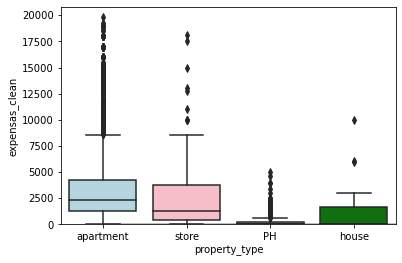

In [13]:
#Analizo las expensas
dataPCaba['expensas_clean'] = dataPCaba['expensas_clean'].astype(float)
print(dataPCaba['expensas_clean'].max())
print(dataPCaba['expensas_clean'].mean())
maskExp = dataPCaba.expensas_clean<20000
sns.histplot(dataPCaba[maskExp].expensas_clean, stat= 'probability',kde=False, color = "blue");

fig= plt.plot( figsize=(10,7))
palette_tp=["lightblue", "lightpink", "violet", "green"]
sns.boxplot(x = "property_type", y = "expensas_clean", data=dataPCaba[maskExp],palette=palette_tp);

In [14]:
#Separo las expensas en 3 categorias.
# Separo las distancias en 3 categorias
distaExpCat = pd.cut(dataPCaba.expensas_clean,  [0, 2500, 5000, 10000000], labels=['Bajas', 'Medias', 'Altas'])
dataPCaba['nivelExpensas'] = distaExpCat
maskConExpensas = dataPCaba.expensas_clean > 0
dataPCaba[maskConExpensas].head(3)

,Unnamed: 0,operation,property_type,place_name,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,sup_total_m2_clean,sup_cubierta_m2_clean,precio_clean,luxury,precio_x_m_clean,rooms_calc,antiguedad,caracteristicas,expensas_clean,nivelExpensas
15,52,sell,apartment,Caballito,-34.622211,-58.439128,110000.0,USD,1940895.00,110000.0,...,50.0,50.0,110000.0,NaN,2200.000000,3.0,50.0,|,1350.0,Bajas
22,66,sell,apartment,Boedo,-34.618777,-58.402645,72900.0,USD,1286284.05,72900.0,...,38.0,0.0,72900.0,NaN,1918.421053,NaN,NaN,|,1200.0,Bajas
23,98,sell,apartment,Almagro,NaN,NaN,109900.0,USD,1939130.55,109900.0,...,50.0,40.0,109900.0,NaN,2198.000000,2.0,NaN,|Piscina|Estrenar|Parrilla|Solarium|,1577.0,Bajas


In [15]:
#Transformo el dataFrame de propiedades caba en geoDataframe
geometria = gpd.points_from_xy(dataPCaba.lon, dataPCaba.lat)
geo_dataP_cabaSn = gpd.GeoDataFrame(dataPCaba ,geometry=geometria)
geo_dataP_cabaSn.head(4)

,Unnamed: 0,operation,property_type,place_name,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,sup_total_m2_clean,sup_cubierta_m2_clean,precio_clean,luxury,precio_x_m_clean,rooms_calc,antiguedad,caracteristicas,expensas_clean,nivelExpensas
0,0,sell,PH,Mataderos,-34.661824,-58.508839,62000.0,USD,1093959.0,62000.0,...,55.0,40.0,62000.0,NaN,1127.272727,NaN,NaN,|,NaN,NaN
1,2,sell,apartment,Mataderos,-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,...,55.0,55.0,72000.0,NaN,1309.090909,NaN,NaN,|,NaN,NaN
2,7,sell,apartment,Belgrano,-34.559873,-58.443362,138000.0,USD,2434941.0,138000.0,...,45.0,40.0,138000.0,NaN,3066.666667,NaN,NaN,|Piscina|Estrenar|Solarium|,NaN,NaN
3,8,sell,apartment,Belgrano,-34.559873,-58.443362,195000.0,USD,3440677.5,195000.0,...,65.0,60.0,195000.0,NaN,3000.000000,NaN,NaN,|Piscina|Estrenar|Solarium|,NaN,NaN


In [16]:
# Sumo el dataFrame de estaciones de subte
data_location = "./data/estaciones-de-subte.csv"
dataSubte = pd.read_csv(data_location, sep=',')
dataSubte.head(3)

,long,lat,id,estacion,linea
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H


In [17]:
#Transformo el dataFrame en geoDataframe
geo_subte = gpd.GeoDataFrame(dataSubte,geometry=gpd.points_from_xy(dataSubte.long, dataSubte.lat))
geo_subte.head(3)

,long,lat,id,estacion,linea,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)


In [18]:
#Transformo el dataFrame en geoDataframe
geo_subte = gpd.GeoDataFrame(dataSubte,geometry=gpd.points_from_xy(dataSubte.long, dataSubte.lat))
geo_subte.head(3)

,long,lat,id,estacion,linea,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)


In [19]:
# Sumo los barrios oficilas de la ciudad de la Bs As
dataBa_location = "./data/barrios.geojson"
geo_dataBa = gpd.read_file(dataBa_location)

In [20]:
#Calculo la distancia menor a una estación de subte
geo_dataP_cabaSn["distancia_min"] = np.min(spatial.distance.cdist(
    geo_dataP_cabaSn[["lon", "lat"]], geo_subte[["long", "lat"]]
    ), axis=1).round(4)
geo_dataP_cabaSn.sort_values(by='distancia_min', ascending=False).head(3)

,Unnamed: 0,operation,property_type,place_name,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,sup_cubierta_m2_clean,precio_clean,luxury,precio_x_m_clean,rooms_calc,antiguedad,caracteristicas,expensas_clean,nivelExpensas,distancia_min
5377,28512,sell,apartment,Mataderos,-38.416097,-63.616672,45000.0,USD,794002.5,45000.0,...,70.0,45000.0,NaN,642.857143,3.0,NaN,|,NaN,NaN,6.3881
2053,12743,sell,PH,Villa Real,-34.629238,-58.534858,80000.0,USD,1411560.0,80000.0,...,72.0,80000.0,NaN,952.380952,NaN,NaN,|,NaN,NaN,0.0652
17783,99993,sell,house,Liniers,-34.652432,-58.528231,179000.0,USD,3158365.5,179000.0,...,0.0,179000.0,NaN,1491.666667,NaN,NaN,|,NaN,NaN,0.0625


In [21]:
# Separo las distancias en 3 categorias
distaQCat = pd.cut(geo_dataP_cabaSn.distancia_min,  [-1, 0.005, 0.01, 1], labels=['Cerca', 'Medio', 'Lejos'])
print(distaQCat)
geo_dataP_cabaSn['distanciaSubte'] = distaQCat
geo_dataP_cabaSn.head(3)

0        Lejos
1        Lejos
2        Lejos
3        Lejos
4          NaN
         ...  
20625      NaN
20626    Cerca
20627    Medio
20628      NaN
20629    Medio
Name: distancia_min, Length: 20630, dtype: category
Categories (3, object): ['Cerca' < 'Medio' < 'Lejos']


,Unnamed: 0,operation,property_type,place_name,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,precio_clean,luxury,precio_x_m_clean,rooms_calc,antiguedad,caracteristicas,expensas_clean,nivelExpensas,distancia_min,distanciaSubte
0,0,sell,PH,Mataderos,-34.661824,-58.508839,62000.0,USD,1093959.0,62000.0,...,62000.0,NaN,1127.272727,NaN,NaN,|,NaN,NaN,0.0500,Lejos
1,2,sell,apartment,Mataderos,-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,...,72000.0,NaN,1309.090909,NaN,NaN,|,NaN,NaN,0.0575,Lejos
2,7,sell,apartment,Belgrano,-34.559873,-58.443362,138000.0,USD,2434941.0,138000.0,...,138000.0,NaN,3066.666667,NaN,NaN,|Piscina|Estrenar|Solarium|,NaN,NaN,0.0102,Lejos


In [22]:
#Agrego un valor se "sentimiento" al campo detalle
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
geo_dataP_cabaSn['valorDetalle'] = geo_dataP_cabaSn["description"].apply(lambda x: x if x is np.NaN else sentiment.sentiment(x))

In [23]:
# Categorizo los valores de los sentimientos para usarlos como size del grafico
#geo_dataP_cabaSn.valorDetalle.value_counts()
#print(geo_dataP_cabaSn.valorDetalle.max())
#print(geo_dataP_cabaSn.valorDetalle.min())

valorDetQCat = pd.cut(geo_dataP_cabaSn.valorDetalle,  [0, 0.03, 0.08, 1], labels=[1, 3, 5])
print(valorDetQCat)
geo_dataP_cabaSn['valorDetalleRango'] = valorDetQCat

0        5
1        5
2        5
3        5
4        5
        ..
20625    1
20626    5
20627    5
20628    5
20629    5
Name: valorDetalle, Length: 20630, dtype: category
Categories (3, int64): [1 < 3 < 5]


In [24]:
#Agrego la información de delitos y analizo los datos del dataset
dataD2021_location = "./data/delitos_2021.csv"
dataD2021 = pd.read_csv(dataD2021_location, sep=";", low_memory=False)
#Agrego la información de delitos de otros años
dataD2016_location = "./data/delitos_2016.csv"
dataD2016 = pd.read_csv(dataD2016_location, sep=",", low_memory=False)
dataD2017_location = "./data/delitos_2017.csv"
dataD2017 = pd.read_csv(dataD2017_location, sep=",", low_memory=False)
dataD2018_location = "./data/delitos_2018.csv"
dataD2018 = pd.read_csv(dataD2018_location, sep=",", low_memory=False)
dataD2019_location = "./data/delitos_2019.csv"
dataD2019 = pd.read_csv(dataD2019_location, sep=",", low_memory=False)
dataD2020_location = "./data/delitos_2020.csv"
dataD2020 = pd.read_csv(dataD2020_location, sep=",", low_memory=False)

print(dataD2021.head(2))
print(dataD2021.subtipo.value_counts())
print(dataD2021.tipo.value_counts())
print(dataD2021.barrio.value_counts())

print(dataD2021.columns)
print(dataD2020.columns)
print(dataD2019.columns)
print(dataD2018.columns)
print(dataD2017.columns)
print(dataD2016.columns)

dataD2021.rename(columns = {'id-mapa':'id', 'franja':'franja_horaria', 'tipo':'tipo_delito', 'subtipo':'subtipo_delito',\
                           'latitud':'lat', 'longitud':'long', 'cantidad':'cantidad_registrada'}, inplace = True)
dataD2020.rename(columns = {'id-mapa':'id', 'franja':'franja_horaria', 'tipo':'tipo_delito', 'subtipo':'subtipo_delito',\
                           'latitud':'lat', 'longitud':'long', 'cantidad':'cantidad_registrada'}, inplace = True)



dataD = pd.concat([dataD2021, dataD2016, dataD2017, dataD2018, dataD2019, dataD2020], ignore_index=True)
dataD.head()

           id-mapa  anio    mes        dia       fecha franja       tipo  \
0  HC-2021-1008202  2021  Enero  Miércoles  06/01/2021     18  Homicidio   
1  HC-2021-1009094  2021  Enero     Jueves  07/01/2021     10  Homicidio   

          subtipo uso_armas        barrio  comuna       latitud      longitud  \
0  Siniestro Vial       NaN  Constitución     1.0     -34,62761    -58,379146   
1  Siniestro Vial       NaN     Mataderos     9.0  -34,64972969  -58,51058958   

   cantidad  
0       1.0  
1       1.0  
Siniestro Vial     7200
Con uso de moto    4623
Hurto Automotor    3674
Robo Automotor      725
Doloso               84
Femicidio            15
Name: subtipo, dtype: int64
Robo (con violencia)     44825
Hurto (sin violencia)    36443
Lesiones                  7106
Homicidio                  193
Name: tipo, dtype: int64
Palermo              7785
Balvanera            5952
Flores               4842
Recoleta             4397
Caballito            4046
Almagro              3590
Villa Lu

,id,anio,mes,dia,fecha,franja_horaria,tipo_delito,subtipo_delito,uso_armas,barrio,comuna,lat,long,cantidad_registrada,id_mapa,victimas
0,HC-2021-1008202,2021.0,Enero,Miércoles,06/01/2021,18,Homicidio,Siniestro Vial,NaN,Constitución,1.0,"-34,62761","-58,379146",1.0,NaN,NaN
1,HC-2021-1009094,2021.0,Enero,Jueves,07/01/2021,10,Homicidio,Siniestro Vial,NaN,Mataderos,9.0,"-34,64972969","-58,51058958",1.0,NaN,NaN
2,HC-2021-1013236,2021.0,Enero,Domingo,10/01/2021,7,Homicidio,Siniestro Vial,NaN,Parque Chacabuco,7.0,"-34,62917196","-58,43058079",1.0,NaN,NaN
3,HC-2021-1014154,2021.0,Enero,Lunes,11/01/2021,9,Homicidio,Siniestro Vial,NaN,Nueva Pompeya,5.0,"-34,63867577","-58,4145554",1.0,NaN,NaN
4,HC-2021-1015476,2021.0,Enero,Lunes,11/01/2021,21,Homicidio,Siniestro Vial,NaN,Parque Avellaneda,9.0,"-34,64771436","-58,46806552",1.0,NaN,NaN


In [25]:
# Me quedo con la información de robo, hurto y homicidio pero sin el subtipo Siniestro Vial 
# Podemos agregar el indice de delitos por barrio para calcular el precio.
maskTipo = (dataD['tipo_delito'] == 'Robo (con violencia)') | (dataD['tipo_delito'] == 'Hurto (sin violencia)') | (dataD['tipo_delito'] == 'Homicidio') & (dataD['subtipo_delito']!='Siniestro Vial')
dataD_imp = dataD.loc[maskTipo]

dataD_G = dataD_imp.groupby(by='barrio').sum().sort_values(by='cantidad_registrada', ascending=False)
dataD_G.head()

,anio,comuna,cantidad_registrada,victimas
barrio,,,,
Palermo,25057357.0,678468.0,26875.0,6.0
Balvanera,19599545.0,124065.0,22693.0,6.0
Flores,15285791.0,215845.0,18029.0,10.0
San Nicolás,7877959.0,26442.0,16421.0,2.0
Caballito,13222647.0,165936.0,16391.0,3.0


In [26]:
# Genero una serie con los barrios y la cantidad de delitos.
dataD_G_BC = dataD_G.loc[:,'cantidad_registrada']
dataD_G_BC.index

Index(['Palermo', 'Balvanera', 'Flores', 'San Nicolás', 'Caballito',
       'Recoleta', 'Almagro', 'Belgrano', 'Villa Lugano', 'Barracas',
       'Constitución', 'Villa Crespo', 'Retiro', 'Mataderos', 'Monserrat',
       'Parque Chacabuco', 'Nueva Pompeya', 'Villa Urquiza', 'Liniers',
       'Villa Devoto', 'Parque Patricios', 'San Cristóbal', 'Boedo',
       'Parque Avellaneda', 'Nuñez', 'Saavedra', 'Villa Soldati', 'Boca',
       'San Telmo', 'Floresta', 'Chacarita', 'Villa del Parque', 'Colegiales',
       'Villa Gral. Mitre', 'Vélez Sársfield', 'Villa Santa Rita',
       'Villa Luro', 'Villa Pueyrredón', 'Monte Castro', 'Paternal',
       'Villa Ortuzar', 'Villa Riachuelo', 'Coghlan', 'Versalles',
       'Villa Real', 'Parque Chas', 'Agronomía', 'Puerto Madero',
       'Nueva pompeya', 'Villa Del Parque'],
      dtype='object', name='barrio')

In [27]:
#Agrego la cantidad de delitos por barrio de los ultimos 6 años
geo_dataP_cabaSn['cantDelitos'] = geo_dataP_cabaSn.place_name.apply(lambda x: x if x is np.NaN \
                                                                    else fu.obtenerInformacion(x, dataD_G_BC))

geo_dataP_cabaSn.head()


,Unnamed: 0,operation,property_type,place_name,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,rooms_calc,antiguedad,caracteristicas,expensas_clean,nivelExpensas,distancia_min,distanciaSubte,valorDetalle,valorDetalleRango,cantDelitos
0,0,sell,PH,Mataderos,-34.661824,-58.508839,62000.0,USD,1093959.00,62000.0,...,NaN,NaN,|,NaN,NaN,0.0500,Lejos,0.572144,5,8224.0
1,2,sell,apartment,Mataderos,-34.652262,-58.522982,72000.0,USD,1270404.00,72000.0,...,NaN,NaN,|,NaN,NaN,0.0575,Lejos,0.998854,5,8224.0
2,7,sell,apartment,Belgrano,-34.559873,-58.443362,138000.0,USD,2434941.00,138000.0,...,NaN,NaN,|Piscina|Estrenar|Solarium|,NaN,NaN,0.0102,Lejos,0.999974,5,11189.0
3,8,sell,apartment,Belgrano,-34.559873,-58.443362,195000.0,USD,3440677.50,195000.0,...,NaN,NaN,|Piscina|Estrenar|Solarium|,NaN,NaN,0.0102,Lejos,0.999952,5,11189.0
4,13,sell,apartment,Palermo Soho,NaN,NaN,111700.0,USD,1970890.65,111700.0,...,1.0,NaN,|Piscina|Solarium|,NaN,NaN,NaN,NaN,1.000000,5,NaN


In [28]:
# Separo la cantidad de delitos en 3 categorias

distaQCD = pd.qcut(geo_dataP_cabaSn.cantDelitos,  3, labels=['Baja', 'Media', 'Alta'])
print(distaQCD)
geo_dataP_cabaSn['Delincuencia'] = distaQCD
geo_dataP_cabaSn.head(3)

0        Media
1        Media
2        Media
3        Media
4          NaN
         ...  
20625    Media
20626    Media
20627    Media
20628    Media
20629     Baja
Name: cantDelitos, Length: 20630, dtype: category
Categories (3, object): ['Baja' < 'Media' < 'Alta']


,Unnamed: 0,operation,property_type,place_name,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,antiguedad,caracteristicas,expensas_clean,nivelExpensas,distancia_min,distanciaSubte,valorDetalle,valorDetalleRango,cantDelitos,Delincuencia
0,0,sell,PH,Mataderos,-34.661824,-58.508839,62000.0,USD,1093959.0,62000.0,...,NaN,|,NaN,NaN,0.0500,Lejos,0.572144,5,8224.0,Media
1,2,sell,apartment,Mataderos,-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,...,NaN,|,NaN,NaN,0.0575,Lejos,0.998854,5,8224.0,Media
2,7,sell,apartment,Belgrano,-34.559873,-58.443362,138000.0,USD,2434941.0,138000.0,...,NaN,|Piscina|Estrenar|Solarium|,NaN,NaN,0.0102,Lejos,0.999974,5,11189.0,Media


In [29]:
# Agrego la información del flujo vehicular
dataF_location = "./data/dataset_flujo_vehicular.csv"
dataF = pd.read_csv(dataF_location, sep=",")
# Descartado por poca información
dataF.LATITUD.value_counts()

-34.588796    52812
-34.633299    49857
-34.579632    33048
-34.618036    17694
-34.608550    17544
-34.536980    15457
Name: LATITUD, dtype: int64

In [30]:
# Puestos de bicicletas de la ciudad.
dataBi_location = "./data/estaciones_sistema_viejo.csv"
dataBi = pd.read_csv(dataBi_location, sep=",")
dataBi.head(4)

,id_estacion,nombre_estacion,long_estacion,lat_estacion,domicilio_estacion,tipo_estacion,observaciones,horario_estacion
0,1.0,Facultad de Derecho,-58.392452,-34.583133,Av. Pres.Figueroa Alcorta y Juan A.Bibiloni,AUTOMÁTICA,Abril 2015 (pasó de ser Manual a Automática),Estación automática: disponibilidad las 24 horas
1,2.0,Retiro,-58.374822,-34.592589,Av. Dr.Jose Ramos Mejia y Del Libertador Av,AUTOMÁTICA,Abril 2015 (pasó de ser Manual a Automática),Estación automática: disponibilidad las 24 horas
2,3.0,Aduana,-58.368918,-34.611242,Av. Ing.Huergo y Av. Belgrano,AUTOMÁTICA,Abril 2015 (pasó de ser Manual a Automática),Estación automática: disponibilidad las 24 horas
3,4.0,Plaza Roma,-58.368950,-34.601721,Lavalle y Bouchard,AUTOMÁTICA,Abril 2015 (pasó de ser Manual a Automática),Estación automática: disponibilidad las 24 horas


In [31]:
#Calculo la distancia menor a una estación de bicicletas
geometriaBi = gpd.points_from_xy(dataBi.long_estacion, dataBi.lat_estacion)
geo_dataBi = gpd.GeoDataFrame(dataBi ,geometry=geometriaBi)
geo_dataBi.dropna(how='any', subset=['long_estacion','lat_estacion'], inplace=True)


geo_dataP_cabaSn["distancia_minEco"] = np.min(spatial.distance.cdist(
    geo_dataP_cabaSn[["lon", "lat"]], geo_dataBi[["long_estacion", "lat_estacion"]]
    ), axis=1).round(4)
geo_dataP_cabaSn.head(2)

,Unnamed: 0,operation,property_type,place_name,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,caracteristicas,expensas_clean,nivelExpensas,distancia_min,distanciaSubte,valorDetalle,valorDetalleRango,cantDelitos,Delincuencia,distancia_minEco
0,0,sell,PH,Mataderos,-34.661824,-58.508839,62000.0,USD,1093959.0,62000.0,...,|,NaN,NaN,0.0500,Lejos,0.572144,5,8224.0,Media,0.0857
1,2,sell,apartment,Mataderos,-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,...,|,NaN,NaN,0.0575,Lejos,0.998854,5,8224.0,Media,0.0923


In [32]:
# Separo las distancias a las estadiones de bicicleta en 3 categorias
distaQCat = pd.cut(geo_dataP_cabaSn.distancia_minEco,  [-1, 0.005, 0.01, 1], labels=['Cerca', 'Medio', 'Lejos'])
print(distaQCat)
geo_dataP_cabaSn['distanciaEcoBici'] = distaQCat
geo_dataP_cabaSn.head(3)

0        Lejos
1        Lejos
2        Lejos
3        Lejos
4          NaN
         ...  
20625      NaN
20626    Cerca
20627    Lejos
20628      NaN
20629    Lejos
Name: distancia_minEco, Length: 20630, dtype: category
Categories (3, object): ['Cerca' < 'Medio' < 'Lejos']


,Unnamed: 0,operation,property_type,place_name,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,expensas_clean,nivelExpensas,distancia_min,distanciaSubte,valorDetalle,valorDetalleRango,cantDelitos,Delincuencia,distancia_minEco,distanciaEcoBici
0,0,sell,PH,Mataderos,-34.661824,-58.508839,62000.0,USD,1093959.0,62000.0,...,NaN,NaN,0.0500,Lejos,0.572144,5,8224.0,Media,0.0857,Lejos
1,2,sell,apartment,Mataderos,-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,...,NaN,NaN,0.0575,Lejos,0.998854,5,8224.0,Media,0.0923,Lejos
2,7,sell,apartment,Belgrano,-34.559873,-58.443362,138000.0,USD,2434941.0,138000.0,...,NaN,NaN,0.0102,Lejos,0.999974,5,11189.0,Media,0.0176,Lejos


In [33]:
# Establecimientos educativos
dataE_location = "./data/establecimientos_educativos_WGS84.csv"
dataE = pd.read_csv(dataE_location, sep=",")
dataEstaEducBarrio =  dataE.groupby(by='barrio').count()
serieEstEducBarrio = dataEstaEducBarrio['cui']
serieEstEducBarrio.index

Index(['AGRONOMIA', 'ALMAGRO', 'BALVANERA', 'BARRACAS', 'BELGRANO', 'BOCA',
       'BOEDO', 'CABALLITO', 'CHACARITA', 'COGHLAN', 'COLEGIALES',
       'CONSTITUCION', 'FLORES', 'FLORESTA', 'LINIERS', 'MATADEROS',
       'MONTE CASTRO', 'MONTSERRAT', 'NUEVA POMPEYA', 'NUÑEZ', 'PALERMO',
       'PARQUE AVELLANEDA', 'PARQUE CHACABUCO', 'PARQUE CHAS',
       'PARQUE PATRICIOS', 'PATERNAL', 'PUERTO MADERO', 'RECOLETA', 'RETIRO',
       'SAAVEDRA', 'SAN CRISTOBAL', 'SAN NICOLAS', 'SAN NIICOLAS', 'SAN TELMO',
       'VELEZ SARSFIELD', 'VERSALLES', 'VILLA CRESPO', 'VILLA DEL PARQUE',
       'VILLA DEVOTO', 'VILLA GRAL. MITRE', 'VILLA LUGANO', 'VILLA LURO',
       'VILLA ORTUZAR', 'VILLA PUEYRREDON', 'VILLA REAL', 'VILLA RIACHUELO',
       'VILLA SANTA RITA', 'VILLA SOLDATI', 'VILLA URQUIZA'],
      dtype='object', name='barrio')

In [34]:
#Agrego la cantidad de establecimeintos educativos por barrio
geo_dataP_cabaSn['cantEducacion'] = geo_dataP_cabaSn.place_name.apply(lambda x: x if x is np.NaN \
                                                                      else fu.obtenerInformacion(x.upper(), serieEstEducBarrio))

geo_dataP_cabaSn.head()

,Unnamed: 0,operation,property_type,place_name,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,nivelExpensas,distancia_min,distanciaSubte,valorDetalle,valorDetalleRango,cantDelitos,Delincuencia,distancia_minEco,distanciaEcoBici,cantEducacion
0,0,sell,PH,Mataderos,-34.661824,-58.508839,62000.0,USD,1093959.00,62000.0,...,NaN,0.0500,Lejos,0.572144,5,8224.0,Media,0.0857,Lejos,68.0
1,2,sell,apartment,Mataderos,-34.652262,-58.522982,72000.0,USD,1270404.00,72000.0,...,NaN,0.0575,Lejos,0.998854,5,8224.0,Media,0.0923,Lejos,68.0
2,7,sell,apartment,Belgrano,-34.559873,-58.443362,138000.0,USD,2434941.00,138000.0,...,NaN,0.0102,Lejos,0.999974,5,11189.0,Media,0.0176,Lejos,104.0
3,8,sell,apartment,Belgrano,-34.559873,-58.443362,195000.0,USD,3440677.50,195000.0,...,NaN,0.0102,Lejos,0.999952,5,11189.0,Media,0.0176,Lejos,104.0
4,13,sell,apartment,Palermo Soho,NaN,NaN,111700.0,USD,1970890.65,111700.0,...,NaN,NaN,NaN,1.000000,5,NaN,NaN,NaN,NaN,NaN


In [35]:
# Mapa de ruido
dataRu_location = "./data/mapa_de_ruido_diurno.csv"
geo_dataRu = gpd.read_file(dataRu_location, sep=",")
geo_dataRu.head(4)

,wkt,limite_inferior_rango_db,limite_superior_rango_db,comuna,leyenda,rango_db,color,periodo,geometry
0,MULTIPOLYGON (((-58.3714231269834 -34.57855223...,30.0,35.0,1,35 dBA o menos,30-35,169 255 115,Diurno,"MULTIPOLYGON (((-58.37142 -34.57855, -58.37150..."
1,MULTIPOLYGON (((-58.3714231269834 -34.57855223...,35.0,40.0,1,35-40 dBA,35-40,76 230 0,Diurno,"MULTIPOLYGON (((-58.37142 -34.57855, -58.37142..."
2,MULTIPOLYGON (((-58.3714231117057 -34.57856621...,40.0,45.0,1,40-45 dBA,40-45,38 115 0,Diurno,"MULTIPOLYGON (((-58.37142 -34.57857, -58.37142..."
3,MULTIPOLYGON (((-58.3719240383553 -34.57857520...,45.0,50.0,1,45-50 dBA,45-50,255 255 0,Diurno,"MULTIPOLYGON (((-58.37192 -34.57858, -58.37197..."


In [ ]:
import time
inicio = time.time()
# Tarda alrededor de 10 minutos

#Obtengo cuantos decibeles hay en cada propiedad
max_count = geo_dataP_cabaSn[geo_dataP_cabaSn['geometry'].is_valid].shape[0]

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

geo_dataP_cabaSn['db'] = geo_dataP_cabaSn[geo_dataP_cabaSn['geometry'].is_valid].geometry.apply(lambda x: fu.obtenerValorPorCercania(x, geo_dataRu, 'limite_superior_rango_db', f))

fin = time.time()
print(fin-inicio)

geo_dataP_cabaSn.head(3)


IntProgress(value=0, max=16041)

In [ ]:
# Separo las distancias en 3 categorias
geo_dataP_cabaSn['db'] = geo_dataP_cabaSn['db'].astype(float)
distaQCatRuido = pd.cut(geo_dataP_cabaSn.db,  [30, 50, 75, 100], labels=['Bajo', 'Medio', 'Alto'])

geo_dataP_cabaSn['nivelRuido'] = distaQCatRuido
geo_dataP_cabaSn.head(3)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
#geo_dataP_cabaSn.distancia_min.max()
mask = geo_dataP_cabaSn.distancia_min < 1
dataP_cabaG = geo_dataP_cabaSn[mask]

geo_dataBa.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_dataRu.plot(ax=ax, color='red', markersize=10, zorder=5)

dataP_cabaG.plot(ax=ax, color='blue', markersize=1, zorder=3)

In [ ]:
#Agrego los datos de los espacios verdes.
dataVerde_location = "./data/espacio-verde-publico.csv"
geo_dataVerde = gpd.read_file(dataVerde_location, sep=",")
geo_dataVerde.head(4)

In [ ]:
maskC = (geo_dataVerde.clasificac == 'PARQUE') | (geo_dataVerde.clasificac == 'PLAZA')
geo_parques = geo_dataVerde[maskC]
geo_parques['geometry'] = geo_parques.WKT.apply(wkt.loads)
geo_parques.head(3)

geo_parques['BarrioOficial'] = geo_parques.geometry.apply (lambda x: x if x is np.NaN \
                                                           else fu.obtenerValorPorPunto(x, geo_dataBa, 'BARRIO'))

In [ ]:
#Obtengo la superficie verde por barrio
geo_parques['area'] = geo_parques['area'].astype(float)
#print(geo_parques.groupby(by='BarrioOficial')['geometry'].area.mean())
dataVerdebarrio = geo_parques.groupby(by='BarrioOficial')['BarrioOficial','geometry'].head()
dataVerdebarrio['superficie'] = dataVerdebarrio.geometry.area
superficieVerdeBarrio = dataVerdebarrio.groupby(by='BarrioOficial')['superficie'].apply(sum)
superficieVerdeBarrio.head()


In [ ]:
#Genero un nuevo dataframe con la informacion
dataVerdeBarrio = pd.DataFrame(superficieVerdeBarrio)
dataVerdeBarrio['BarrioOficial'] = dataVerdeBarrio.index
dataVerdeBarrio = dataVerdeBarrio.rename_axis('index').reset_index()
dataVerdeBarrio.head(2)

In [ ]:
# Calculo la proporcion de metros cuadrados de plazas/parques por barrio.
geo_dataBa.set_crs("EPSG:4326")
dataAreaBarrio = geo_dataBa.loc[:,['BARRIO','AREA']]
dataAreaBarrio = dataAreaBarrio.rename(columns={'BARRIO':'BarrioOficial', 'AREA':'superficieBarrio'})

dataAreaBarrioVerde = pd.merge(dataAreaBarrio, dataVerdeBarrio, on="BarrioOficial", how='outer')
dataAreaBarrioVerde['superficie'] = dataAreaBarrioVerde['superficie'] * 1000000000
dataAreaBarrioVerde['superficieBarrio'] = dataAreaBarrioVerde['superficieBarrio'].astype(float)
dataAreaBarrioVerde['porcVerde'] = dataAreaBarrioVerde['superficie'] / dataAreaBarrioVerde['superficieBarrio']
dataAreaBarrioVerde.head(2)

In [ ]:
dABVerde = dataAreaBarrioVerde.loc[:,['BarrioOficial', 'porcVerde']]
dABVerde.set_index('BarrioOficial', inplace=True)
dABVerde = dABVerde.fillna(0)
dABVerde

In [ ]:
#Agrego la proporcion de área verde por cada propiedad
geo_dataP_cabaSn['pcAreaVerde'] = geo_dataP_cabaSn.BarrioOficial.apply (lambda x: 0 if x is np.NaN  \
                                                           else dABVerde.loc[x][0])
geo_dataP_cabaSn['pcAreaVerde'] = geo_dataP_cabaSn['pcAreaVerde'].astype(float)

In [ ]:
# Separo las distancias en 3 categorias
distaQCatVerde = pd.cut(geo_dataP_cabaSn.pcAreaVerde,  [0, 0.001, 0.007, 1], labels=['Bajo', 'Medio', 'Alto'])

geo_dataP_cabaSn['nivelVerde'] = distaQCatVerde
geo_dataP_cabaSn.head(3)

In [ ]:
# Reviso la relación entre la cantidad de verde del barrio y el ruido con el precio
maskPrecioO = geo_dataP_cabaSn.precio_x_m_clean < 10000
g = sns.catplot(x="nivelVerde", y="precio_x_m_clean", data=geo_dataP_cabaSn[maskPrecioO], col="nivelRuido")
g.fig.set_size_inches(15,3)


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

#Quitramos los precios muy por encima de la media y la ubicación que no corresponde a ciudad de buenos aires
maskPrecioOUbucacionO = (geo_dataP_cabaSn.precio_x_m_clean < 10000) & (geo_dataP_cabaSn.lat > -38)

# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Precio por merto, 2017', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Añadir la leyenda separada del mapa
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

# Mostrar el mapa finalizado
geo_dataP_cabaSn[maskPrecioOUbucacionO].plot(column='precio_x_m_clean', cmap='plasma', ax=ax, zorder=5)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

#Quitramos los precios muy por encima de la media y la ubicación que no corresponde a ciudad de buenos aires
maskPrecioOUbucacionO = (geo_dataP_cabaSn.precio_x_m_clean < 10000) & (geo_dataP_cabaSn.lat > -38)

# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
 
# Control del encuadre (área geográfica) del mapa
ax.axis([-58.6, -58.3, -34.75, -34.5])
 
# Control del título y los ejes
ax.set_title('Precio por metro cuadrado, 2017', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
 
# Añadir la leyenda separada del mapa
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
 
# Generar y cargar el mapa
geo_dataP_cabaSn[maskPrecioOUbucacionO].plot(column='precio_x_m_clean', cmap='plasma', ax=ax,
              legend=True, cax=cax, zorder=5)
 
# Cargar un mapa base con contornos de países
geo_dataBa.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_dataBa.plot(ax=ax, color='#89c0e8', zorder=0)

In [ ]:
#Quitramos los precios muy por encima de la media y la ubicación que no corresponde a ciudad de buenos aires
maskPrecioOUbucacionO = (geo_dataP_cabaSn.precio_x_m_clean < 10000) & (geo_dataP_cabaSn.lat > -38)

serieD = geo_dataP_cabaSn[maskPrecioOUbucacionO].groupby(by='BarrioOficial').precio_x_m_clean.mean()
datos = serieD.to_frame(name='precioXmetro')
datos.reset_index(inplace=True)


In [ ]:
import json
geoJ_dataBa = geo_dataBa.to_json()
geoJ_dataBa = json.loads(geoJ_dataBa)


datos['BarrioOficial'] = datos.BarrioOficial.apply(lambda x: x if x is np.NaN else x.upper())

#print(datos)
#print(geoJ_dataBa)
fig = go.Figure(go.Choroplethmapbox(name='Propiedades', geojson=geoJ_dataBa, ids=datos['BarrioOficial'], z=datos['precioXmetro'],
                locations=datos['BarrioOficial'], featureidkey='properties.BARRIO', colorscale='reds',                                    
                marker=dict(line=dict(color='black'), opacity=0.6))
               )

fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=10.5, 
                  mapbox_center = {'lat': -34.62, 'lon': -58.4},
                  margin={"r":0,"t":0,"l":0,"b":0}
                 )
fig.update_geos(showcountries=True, showcoastlines=True, showland=True, fitbounds="locations")

fig.show()

In [ ]:
datos = geo_dataP_cabaSn[maskPrecioOUbucacionO]
datos['BarrioOficial'] = datos.BarrioOficial.apply(lambda x: x if x is np.NaN else x.upper())

#print(datos)
#print(geoJ_dataBa)
fig = go.Figure(go.Choroplethmapbox(name='Propiedades', geojson=geoJ_dataBa, ids=datos['BarrioOficial'], z=datos['precio_x_m_clean'],
                locations=datos['BarrioOficial'], featureidkey='properties.BARRIO', colorscale='reds',                                    
                marker=dict(line=dict(color='black'), opacity=0.6))
               )

fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=10.6, 
                  mapbox_center = {'lat': -34.62, 'lon': -58.4},
                  margin={"r":0,"t":0,"l":0,"b":0}
                 )
fig.update_geos(showcountries=True, showcoastlines=True, showland=True, fitbounds="locations")

fig.show()
